# EDA (Exploratory Data Analysis) - Understanding the Data

Im Rahmen der "Understanding the Data"-Phase des QUA3CK-Prozessmodells wird in diesem Notebook die explorative Datenanalyse (EDA) für unser Projekt durchgeführt. 

## Aufgabe 1: Datensatzwahl und -beschreibung

Für unsere Analyse nutzen wir vier zentrale Datenquellen, um den statistischen Zusammenhang zwischen Treibhausgasen, globalen Temperaturanomalien, dem Meeresspiegel und lokalen topografischen Auswirkungen (z. B. Überflutungsflächen) zu untersuchen. Im Folgenden werden die Herkunft, Erhebungsmethoden und die strukturelle Beschaffenheit der ausgewählten Datensätze systematisch dokumentiert.

### 1. NASA GISS Surface Temp (GISTEMP v4)
* **Herkunft (URL):** NASA GISS (Goddard Institute) – https://data.giss.nasa.gov/gistemp/
* **Erhebungsmethode:** Kombiniert historische Messungen von Landstationen und Ozeandaten (ERSSTv5) und rechnet diese auf ein globales 2°×2°-Raster um.
* **Erfassungszeitraum:** 1880 bis heute (monatlich).
* **Datenstruktur:** NetCDF-Format (`.nc`).
  * **Umfang (Zeilen/Spalten):** 1.753 Zeitschritte (Monate seit 1880) auf einem globalen Raster von 90 Breitengraden (lat) x 180 Längengraden (lon). Das entspricht der 2°x2°-Auflösung.
  * **Features & Datentypen:** `tempanomaly` (numerisch/float), `lat` & `lon` (numerisch/float), `time` (kategorial/datetime).
* **Verwendungszweck im Modell:** Dient als historische Basisdaten („Ground Truth“) für das Training der lokalen Temperaturmodelle und als numerischer Input für die globale Heatmap-Visualisierung.

### 2. NOAA Mauna Loa CO₂ Record
* **Herkunft (URL):** NOAA Global Monitoring Laboratory (GML) – https://gml.noaa.gov/ccgg/trends/data.html
* **Erhebungsmethode:** In-situ-Messungen der atmosphärischen CO₂-Konzentration auf dem Mauna Loa Observatorium (längste kontinuierliche Messreihe, „Keeling-Kurve“).
* **Erfassungszeitraum:** 1958 bis heute.
* **Datenstruktur:** CSV-Format.
  * **Umfang (Zeilen/Spalten):** 815 Zeilen (entspricht 815 monatlichen Messpunkten seit 1958) und 8 Spalten (Features).
  * **Features & Datentypen:** `year`, `month` (kategorial/integer, transformiert zu `date` als Index), `average`, `deseasonalized` (numerisch/float).
* **Verwendungszweck im Modell:** Fungiert als zentrales globales Feature (Prädiktor), um den statistischen Zusammenhang zwischen Treibhausgasen und lokaler Temperatur zu lernen.

### 3. Global Mean Sea Level Reconstruction
* **Herkunft (URL):** EPA / CSIRO / NOAA – https://www.cmar.csiro.au/sealevel/sl_data_cmar.html
* **Erhebungsmethode:** Fusioniert historische Pegelmessungen (Tide Gauges) an den Küsten mit hochpräzisen, modernen Satellitendaten.
* **Erfassungszeitraum:** 1880 bis heute.
* **Datenstruktur:** CSV-Format.
  * **Umfang (Zeilen/Spalten):** 134 Zeilen (entspricht 134 jährlichen Messpunkten ab dem Jahr 1880) und 5 Spalten (Features)
  * **Features & Datentypen:** `Year` (transformiert zu datetime-Index), `CSIRO Adjusted Sea Level`, `Lower Error Bound`, `Upper Error Bound` (alle numerisch/float, umgerechnet in cm).
* **Verwendungszweck im Modell:** Dient als historische **Zielvariable (Target)** für das Training des ML-Modells, um den Zusammenhang zwischen Temperaturanstieg und Meeresspiegeländerung vorherzusagen.

### 4. Copernicus DEM (GLO-30)
* **Herkunft (URL):** ESA / OpenTopography / AWS S3 - https://registry.opendata.aws/copernicus-dem/
* **Erhebungsmethode:** Globales digitales Oberflächenmodell (DSM) mit 30m Auflösung, basierend auf weltweiten Satelliten-Radarmessungen (höhere vertikale Genauigkeit als SRTM).
* **Erfassungszeitraum:** Statische Topografie (aktueller wissenschaftlicher Standard).
* **Datenstruktur:** GeoTIFF (über AWS Session geladen).
  * **Umfang:** Globale Raster-Matrix - Genauigkeit 30 Meter.
  * **Features & Datentypen:** Jedes Pixel repräsentiert einen numerischen Höhenwert (Meter über NN).
* **Verwendungszweck im Modell:** Räumliche Basis (globale & regionale Ebene) für die Berechnung von potenziellen Überflutungsflächen im Rahmen der regionalen Risikoanalyse.

---

## Aufgabe 2: Erste Visualisierungen erstellen

Visualisierungen sind ein entscheidender Schritt, um Muster, Trends und Ausreißer in den Rohdaten schnell zu erkennen. Bevor wir mit der eigentlichen grafischen Analyse unserer raumzeitlichen Daten (Zeitreihen und Geodaten) beginnen, bereiten wir unsere Arbeitsumgebung vor.

### Vorbereitung: Bibliotheken importieren
Im ersten Schritt laden wir alle notwendigen Python-Bibliotheken. Neben den Standard-Tools für die Datenmanipulation (`pandas`) und grundlegende Visualisierung (`matplotlib`) nutzen wir spezialisierte Pakete wie `xarray` und `cartopy` für die Klimadaten sowie `rasterio` für den direkten Abruf des digitalen Höhenmodells.

In [9]:
# Importieren der benötigten Bibliotheken
from pathlib import Path
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.session import AWSSession
import numpy as np

### Vorbereitung: Datenpfade definieren und Datensätze laden
Nun definieren wir die lokalen Dateipfade für unsere CSV- und NetCDF-Dateien und laden diese in unsere Arbeitsumgebung ein. Zusätzlich hinterlegen wir die direkte AWS S3-URL für das Copernicus DEM (Digital Elevation Model) der Region Düsseldorf, um diese später direkt aus der Cloud abzurufen.

In [2]:
# Pfade definieren
base_dir = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd() / "data"
co2 = base_dir / "co2_mm_mlo.csv"
sea_level = base_dir / "epa_sea_level.csv"
tempanomaly = base_dir / "gistemp1200_GHCNv4_ERSSTv5.nc"

# Existenz aller Dateien überprüfen
files_to_check = [co2, sea_level, tempanomaly]
missing = [str(f) for f in files_to_check if not f.exists()]
if missing:
    raise FileNotFoundError(f"Folgende Dateien fehlen: {', '.join(missing)}")

# Daten einlesen
df_co2 = pd.read_csv(co2, comment="#", on_bad_lines="skip", engine="python")
df_sea_level = pd.read_csv(sea_level, comment="#", on_bad_lines="skip", engine="python")
dataset_tempanomaly = xr.open_dataset(tempanomaly)

# Die direkte S3-URL für die Kachel Düsseldorf/Rheinland
aws_url_topography = "s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N51_00_E006_00_DEM/Copernicus_DSM_COG_10_N51_00_E006_00_DEM.tif"


### 2.1 Zeitreihenanalyse: CO₂-Konzentration (Mauna Loa)
Das folgende Liniendiagramm veranschaulicht den zeitlichen Verlauf der atmosphärischen CO₂-Konzentration. Die Darstellung der deseasonalisierten Messung hilft dabei, den langfristigen Trend unabhängig von den jährlichen Schwankungen zu identifizieren.

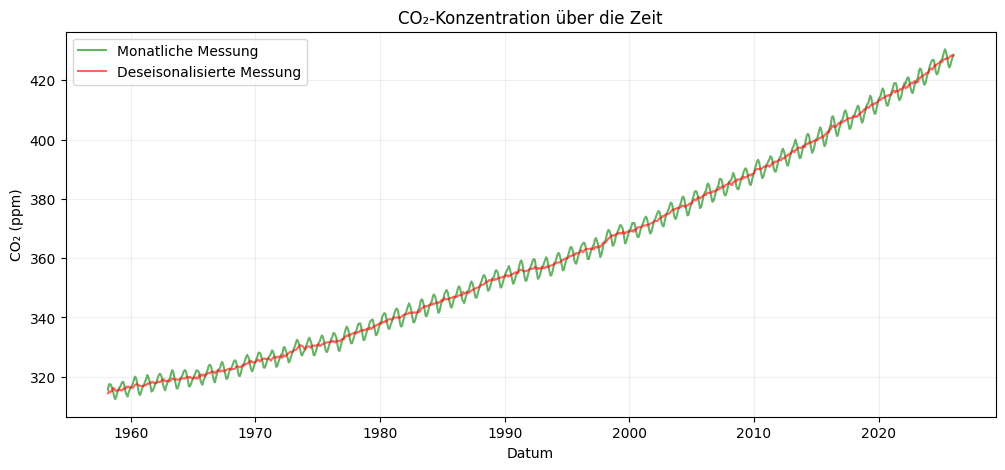

In [3]:
# Zeitspalte erstellen und als Index setzen
df_co2['date'] = pd.to_datetime(df_co2[['year','month']].assign(day=1))
df_co2 = df_co2.set_index('date').sort_index()

# Liniendiagramm erstellen
plt.figure(figsize=(12,5))
plt.plot(df_co2.index, df_co2['average'], color='green', alpha=0.6, label='Monatliche Messung')
plt.plot(df_co2.index, df_co2['deseasonalized'], color='red', alpha=0.6, label='Deseisonalisierte Messung')
plt.title('CO₂-Konzentration über die Zeit')
plt.xlabel('Datum')
plt.ylabel('CO₂ (ppm)')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

### 2.2 Zeitreihenanalyse: Globaler Meeresspiegel
Diese Visualisierung zeigt den Anstieg des globalen mittleren Meeresspiegels. Der schattierte Fehlerbereich (Lower/Upper Error Bound) ist essenziell, um die Unsicherheit historischer Messmethoden korrekt zu interpretieren, bevor die Daten dem Modell übergeben werden.

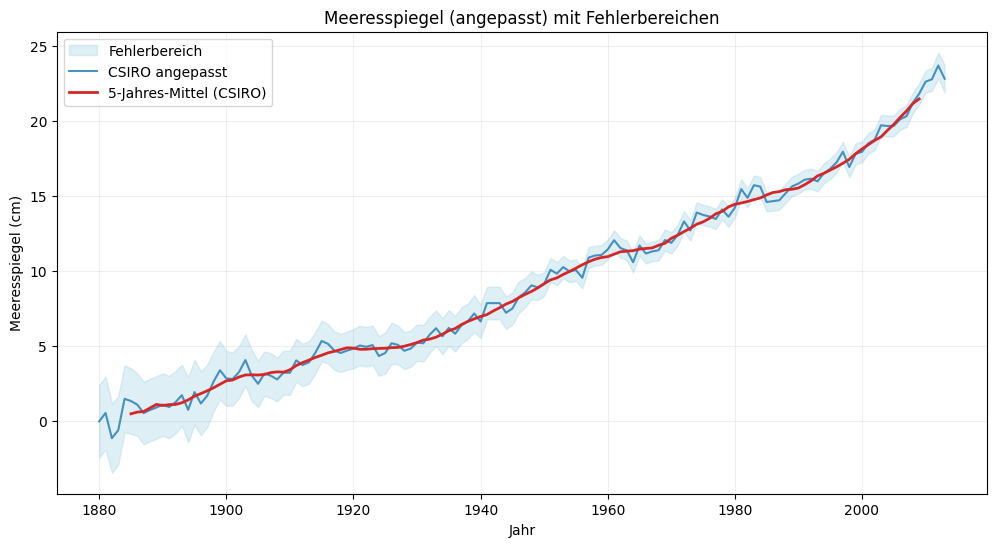

In [4]:
# Zeitspalte erstellen und als Index setzen
df_sea_level['date'] = pd.to_datetime(df_sea_level['Year'].astype(int).astype(str), format='%Y')
df_sea_level = df_sea_level.set_index('date').sort_index()

# Einheiten von Zoll (inch) in Meter umrechnen
inch_to_cm = 2.54
for col in ['Lower Error Bound', 'Upper Error Bound', 'CSIRO Adjusted Sea Level']:
    df_sea_level[col] = df_sea_level[col].astype(float) * inch_to_cm

# Liniendiagramm erstellen
plt.figure(figsize=(12,6))
plt.fill_between(df_sea_level.index, df_sea_level['Lower Error Bound'], df_sea_level['Upper Error Bound'], color='lightblue', alpha=0.4, label='Fehlerbereich')
plt.plot(df_sea_level.index, df_sea_level['CSIRO Adjusted Sea Level'], label='CSIRO angepasst', color='tab:blue', alpha=0.8)
plt.plot(df_sea_level['CSIRO Adjusted Sea Level'].rolling(10, center=True).mean(), color='tab:red', linewidth=2, label='5‑Jahres‑Mittel (CSIRO)')
plt.title('Meeresspiegel (angepasst) mit Fehlerbereichen')
plt.xlabel('Jahr')
plt.ylabel('Meeresspiegel (cm)')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

### 2.3 Räumliche Verteilung: Globale Temperaturanomalien
Um die räumliche Dimension unserer Features zu begreifen, plotten wir die Temperaturanomalien auf einer Weltkarte für einen beispielhaften Zeitpunkt (Januar 2024). Dies hilft bei der Identifizierung lokaler Cluster und regionaler Unterschiede.

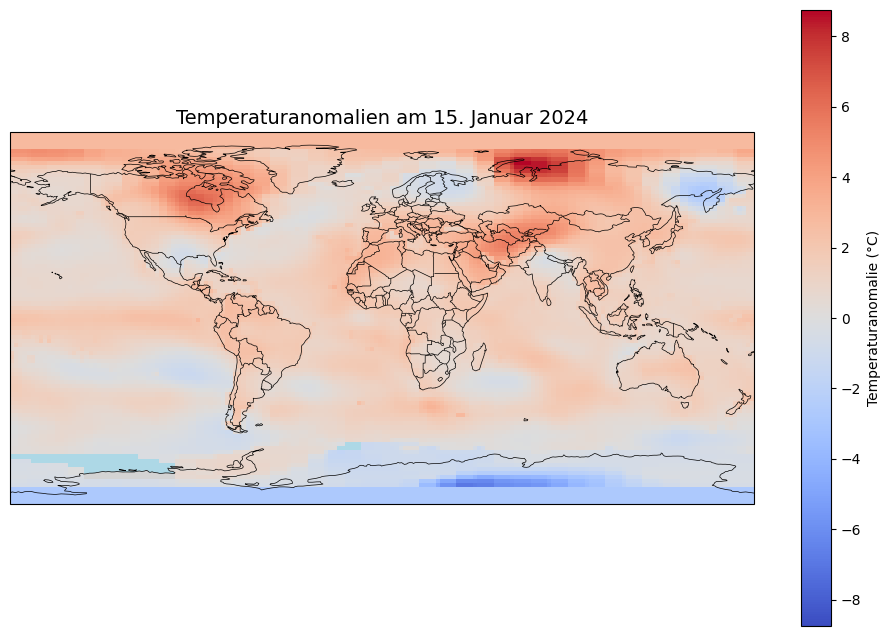

In [5]:
# Jahr für die Auswahl der Daten
year = 2024

# Temperaturanomalien für einen bestimmten Zeitpunkt auswählen
tempanomaly = dataset_tempanomaly["tempanomaly"].sel(time=f"{year}-01-15")

# Plot erstellen
fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}  # Kartenprojektion
)

# Weltkarte hinzufügen
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Küstenlinien
ax.add_feature(cfeature.BORDERS, linewidth=0.5)    # Ländergrenzen
ax.add_feature(cfeature.LAND, facecolor="lightgray")  # Landflächen
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")  # Ozeanflächen

# Temperaturanomalien plotten
tempanomaly.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # Projektion der Daten
    cmap="coolwarm",               # Farbskala
    cbar_kwargs={"label": "Temperaturanomalie (°C)"},  # Farblegende
)

# Titel hinzufügen
ax.set_title(f"Temperaturanomalien am 15. Januar {year}", fontsize=14)

# Plot anzeigen
plt.show()

### 2.4 Topografische Exploration: Digitales Höhenmodell (Düsseldorf)
Für die lokale Risikoanalyse betrachten wir die Topografie einer Zielregion. Das Copernicus Höhenmodell liefert uns die numerische Matrix der Pixelwerte, die wir als Heatmap visualisieren, um spezifische Höhenmuster sichtbar zu machen.

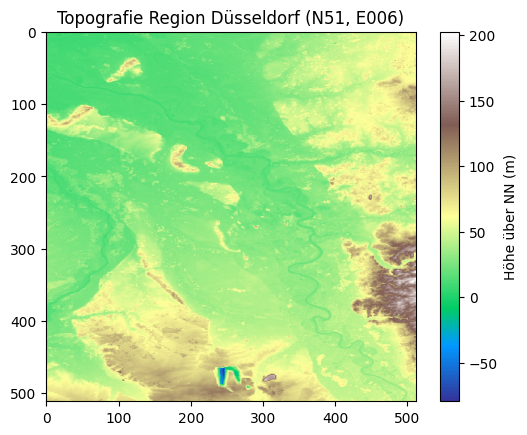

In [6]:
# Umgebung mit anonymem Zugriff starten, Daten verkleinert (512x512) laden und direkt plotten
with rasterio.Env(AWSSession(aws_unsigned=True)):
    with rasterio.open(aws_url_topography) as src:
        plt.imshow(src.read(1, out_shape=(512, 512)), cmap='terrain')
        plt.colorbar(label='Höhe über NN (m)')
        plt.title("Topografie Region Düsseldorf (N51, E006)")
        plt.show()

---

## Aufgabe 3: Fehlende Werte analysieren und bewerten

Nach der ersten visuellen Exploration überprüfen wir die Datenqualität hinsichtlich fehlender Werte (Missing Values). Im QUA3CK-Prozessmodell ist es essenziell, nicht nur zu zählen, *wie viele* Werte fehlen, sondern zu verstehen, *warum* sie fehlen (Missing Completely At Random vs. Structurally Missing).

In [ ]:
# 1. Spezifische Bereinigung des CO2-Datensatzes
# Die NOAA markiert fehlende Metadaten in den frühen Jahren mit spezifischen Platzhaltern
df_co2['ndays'] = df_co2['ndays'].replace(-1, np.nan)
df_co2['sdev'] = df_co2['sdev'].replace(-9.99, np.nan)
df_co2['unc'] = df_co2['unc'].replace(-0.99, np.nan)

print("--- CO2 Datensatz: Fehlende Werte ---")
co2_missing = df_co2.isnull().sum()
co2_missing_pct = (co2_missing / len(df_co2)) * 100
print(pd.DataFrame({'Absolut': co2_missing, 'Prozentual (%)': co2_missing_pct.round(2)}))

print("\n--- Meeresspiegel Datensatz: Fehlende Werte ---")
sea_missing = df_sea_level.isnull().sum()
sea_missing_pct = (sea_missing / len(df_sea_level)) * 100
print(pd.DataFrame({'Absolut': sea_missing, 'Prozentual (%)': sea_missing_pct.round(2)}))

--- CO2 Datensatz: Fehlende Werte ---
                Absolut  Prozentual (%)
year                  0            0.00
month                 0            0.00
decimal date          0            0.00
average               0            0.00
deseasonalized        0            0.00
ndays               195           23.93
sdev                196           24.05
unc                 194           23.80

--- Meeresspiegel Datensatz: Fehlende Werte ---
                          Absolut  Prozentual (%)
Year                            0            0.00
CSIRO Adjusted Sea Level        0            0.00
Lower Error Bound               0            0.00
Upper Error Bound               0            0.00
NOAA Adjusted Sea Level       113           84.33


### Erkenntnisse und Imputationsstrategie

Die Ausgabe zeigt deutlich, dass wir es nicht mit zufällig fehlenden Werten zu tun haben, sondern mit strukturell fehlenden Daten (Missing Not At Random), die historisch und technisch bedingt sind:

1. **CO₂-Daten:** Die Basiswerte (`average`) sind vollständig. Es fehlen lediglich die Metadaten zur Standardabweichung (`sdev`), Unsicherheit (`unc`) und Messtagen (`ndays`) in den frühen Jahren vor 1974. Damals ließen die Messprotokolle des Mauna Loa Observatoriums die Berechnung dieser feingranularen Statistiken noch nicht zu.
2. **Meeresspiegel-Daten:** In der Spalte `NOAA Adjusted Sea Level` fehlen ca. 84 % der Daten. Diese Messungen basieren auf Satelliten-Altimetrie (TOPEX/Poseidon), die erst 1993 begonnen hat. Die Jahre 1880 bis 1992 sind logischerweise leer.

**Strategische Entscheidung (Keine Imputation):**
Vor dem Hintergrund dieser Erkenntnisse wäre eine algorithmische Datenimputation (z.B. Mean- oder KNN-Imputation) grob fehlerhaft. Es ergibt physikalisch und historisch keinen Sinn, Satellitendaten für das 19. Jahrhundert prozentual zu erschließen oder statistische Messunsicherheiten für historische Instrumente zu erfinden. 

* **Konsequenz für das ML-Modell:** Wir verzichten auf eine Imputation. Für das anstehende Training der ML-Modelle werden wir uns stattdessen ausschließlich auf die durchgängig verfügbaren und verlässlichen Kern-Features konzentrieren: Den `average` / `deseasonalized` Wert beim CO₂ und den `CSIRO Adjusted Sea Level` (Pegelmessungen) beim Meeresspiegel. Die unvollständigen Metadaten-Spalten können beim späteren Feature-Selection-Prozess ignoriert werden.

---

## Aufgabe 4: Skalierung und Normalisierung der Daten

Für das Projekt „Degrees of No Return“ kombinieren wir Features mit völlig unterschiedlichen Wertebereichen und physikalischen Einheiten: CO₂-Konzentration (ca. 300–420 ppm), Meeresspiegel (0–25 cm), Temperaturanomalien (-2 bis +3 °C) und topografische Höhen (0 bis >1000 m). 

Ohne Skalierung würden Merkmale mit großen Wertebereichen (wie CO₂ oder Höhenmeter) das Training der Modelle dominieren, was insbesondere bei distanzbasierten Algorithmen oder Neuronalen Netzen zu verzerrten Ergebnissen und schlechter Konvergenz führt.

### 4.1 Wahl der Skalierungsmethoden und Begründung

Basierend auf den Anforderungen unserer geplanten Modellarchitektur wenden wir gezielte Skalierungsstrategien an[cite: 2]:

1. **Tabellarische Zeitreihen (CO₂ & Meeresspiegel):** Wir nutzen den `StandardScaler` (Z-Score-Transformation). Diese Methode zentriert die Daten um den Mittelwert 0 mit einer Standardabweichung von 1. Für statistische Zeitreihenmodelle und lineare Regressionen ist dies ideal, da die Interpretierbarkeit der relativen Schwankungen und Trends erhalten bleibt.
2. **Topografische Geodaten (Copernicus DEM):** Digitale Höhenmodelle werden in räumlichen Machine-Learning-Modellen (z. B. Convolutional Neural Networks zur Überflutungsvorhersage) wie Bilddaten als 2D-Matrizen behandelt. Hier ist die **Min-Max-Skalierung auf den Bereich [0, 1]** der absolute Industriestandard, um eine stabile Netzkonvergenz zu sichern.
3. **Temperaturanomalien (GISTEMP):** *Sonderfall:* Da Anomalien von Natur aus bereits um eine Baseline (Mittelwert) zentriert sind (Werte um 0), verzichten wir hier vorerst auf eine harte Umskalierung, um die direkte physikalische Interpretierbarkeit (z. B. „+1,5 Grad-Ziel“) für die Visualisierungen der WebApp nicht zu zerstören.

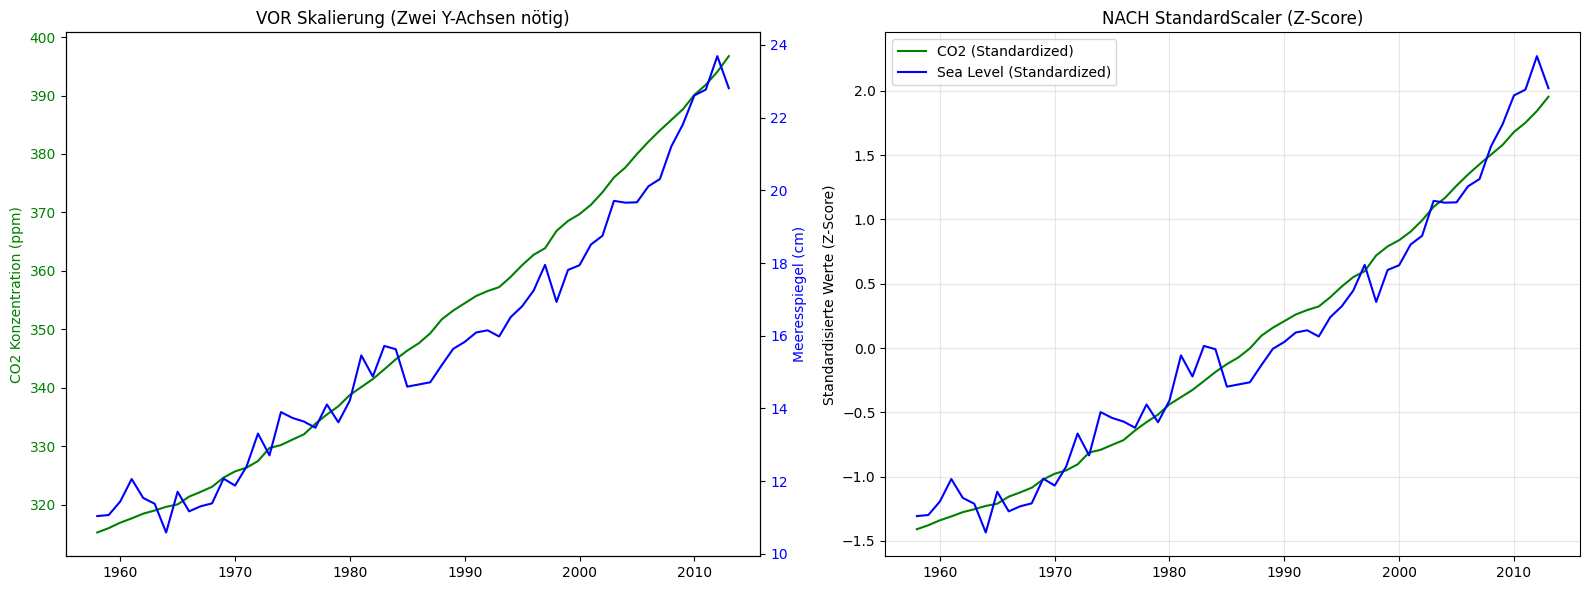

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

# 1. Datenvorbereitung: CO2-Daten auf jährliche Durchschnittswerte aggregieren, um sie mit Sea Level zu mergen
df_co2_yearly = df_co2[['average']].resample('YE').mean()
df_co2_yearly.index = df_co2_yearly.index.year # Index auf reines Jahr setzen

df_sea_yearly = df_sea_level[['CSIRO Adjusted Sea Level']].copy()
df_sea_yearly.index = df_sea_yearly.index.year

# DataFrames zusammenführen (Inner Join über die Jahre, die in beiden existieren)
df_combined = pd.merge(df_co2_yearly, df_sea_yearly, left_index=True, right_index=True)
df_combined.columns = ['CO2 (ppm)', 'Sea Level (cm)']

# 2. Skalierung implementieren (StandardScaler)
scaler_ts = StandardScaler()
df_scaled = pd.DataFrame(
    scaler_ts.fit_transform(df_combined), 
    columns=df_combined.columns, 
    index=df_combined.index
)

# 3. Vorher-Nachher-Vergleich (Scatterplots und Linien)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# VORHER: Unterschiedliche Skalen verzerren das Bild optisch
ax1.plot(df_combined.index, df_combined['CO2 (ppm)'], label='CO2 (ppm)', color='green')
ax1.set_ylabel('CO2 Konzentration (ppm)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax1_twin = ax1.twinx()
ax1_twin.plot(df_combined.index, df_combined['Sea Level (cm)'], label='Sea Level (cm)', color='blue')
ax1_twin.set_ylabel('Meeresspiegel (cm)', color='blue')
ax1_twin.tick_params(axis='y', labelcolor='blue')
ax1.set_title('VOR Skalierung (Zwei Y-Achsen nötig)')

# NACHHER: Auf einer gemeinsamen Skala direkt vergleichbar
ax2.plot(df_scaled.index, df_scaled['CO2 (ppm)'], label='CO2 (Standardized)', color='green')
ax2.plot(df_scaled.index, df_scaled['Sea Level (cm)'], label='Sea Level (Standardized)', color='blue')
ax2.set_title('NACH StandardScaler (Z-Score)')
ax2.set_ylabel('Standardisierte Werte (Z-Score)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Wertebereich VORHER: Min = -79.59174346923828 m, Max = 202.7196807861328 m
Wertebereich NACHHER: Min = 0.0, Max = 1.0


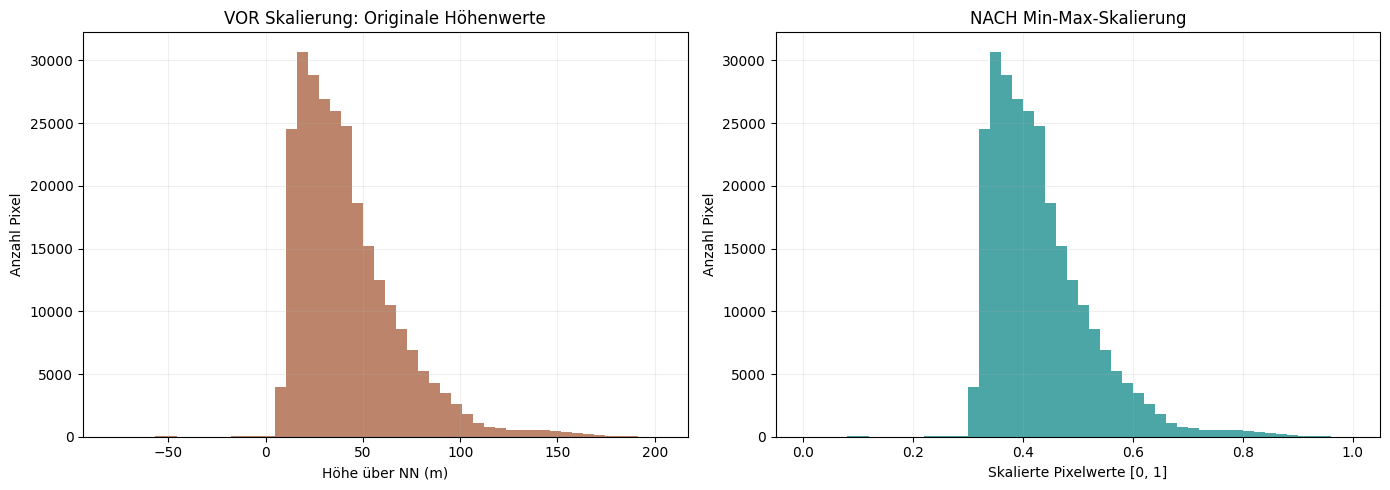

In [ ]:
# 1. Höhenmodell (Copernicus DEM) laden (wie in Aufgabe 2)
with rasterio.Env(AWSSession(aws_unsigned=True)):
    with rasterio.open(aws_url_topography) as src:
        dem_data = src.read(1, out_shape=(512, 512))

# 2. Skalierung implementieren (MinMaxScaler für Bilddaten)
# MinMaxScaler erwartet ein 2D-Array in Form (Samples, Features), daher flatten und reshape
scaler_img = MinMaxScaler()
dem_scaled = scaler_img.fit_transform(dem_data.reshape(-1, 1)).reshape(dem_data.shape)

# 3. Vorher-Nachher-Vergleich (Histogramme der Pixelwerte)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# VORHER: Originale Höhenmeter
ax1.hist(dem_data.flatten(), bins=50, color='sienna', alpha=0.7)
ax1.set_title('VOR Skalierung: Originale Höhenwerte')
ax1.set_xlabel('Höhe über NN (m)')
ax1.set_ylabel('Anzahl Pixel')
ax1.grid(alpha=0.2)

# NACHHER: [0, 1] normiert
ax2.hist(dem_scaled.flatten(), bins=50, color='teal', alpha=0.7)
ax2.set_title('NACH Min-Max-Skalierung')
ax2.set_xlabel('Skalierte Pixelwerte [0, 1]')
ax2.set_ylabel('Anzahl Pixel')
ax2.grid(alpha=0.2)

# Wertebereiche vor und nach der Skalierung ausgeben
print(f"Wertebereich VORHER: Min = {dem_data.min()} m, Max = {dem_data.max()} m")
print(f"Wertebereich NACHHER: Min = {dem_scaled.min()}, Max = {dem_scaled.max()}")

plt.tight_layout()
plt.show()

### 4.2 Dokumentation und erwartete Auswirkungen auf die ML-Algorithmen

Die durchgeführten Skalierungen haben eine direkte, entscheidende Auswirkung auf das anstehende Modelltraining für die WebApp „Degrees of No Return“:

* [cite_start]**Erhaltung der Signalstrukturen:** Wie in den Vorher-Nachher-Plots ersichtlich ist, bleiben die relativen Abstände und Verteilungsformen (Trends, Varianzen) exakt proportional erhalten[cite: 2].
* **Auswirkung auf das Zeitreihen-Modell (Temperatur/CO₂):** Durch den `StandardScaler` wurden CO₂- und Meeresspiegeldaten auf einen gemeinsamen Wertebereich gebracht. Wenn diese Features nun einem Regressionsmodell oder Neuronalen Netz übergeben werden, wird verhindert, dass das Modell dem CO₂-Wert (ursprünglich >300) ein künstlich höheres Gewicht beimisst als dem Meeresspiegel (ursprünglich ~15).
* **Auswirkung auf das Überflutungs-Modell (Copernicus DEM):** Das topografische Raster liegt nun vollständig im Bereich [0, 1]. [cite_start]Für das Training eines Deep-Learning-Modells (z. B. zur semantischen Segmentierung von Überflutungsflächen) ist dies zwingend erforderlich[cite: 2]. [cite_start]Es beschleunigt den Trainingsprozess erheblich, fördert die Konvergenz der Gewichte und beugt explodierenden Gradienten im Netzwerk vor[cite: 2].

---

## Aufgabe 5: Dokumentation und Interpretation der Ergebnisse

Im Rahmen der "Understanding the Data"-Phase des QUA3CK-Prozessmodells wurden die historischen und räumlichen Datengrundlagen für das Projekt „Degrees of No Return“ explorativ analysiert, auf Qualität geprüft und für das maschinelle Lernen aufbereitet.

### 1. Datensatz-Übersicht
Das Projekt stützt sich auf vier zentrale Pfeiler, die unterschiedliche raumzeitliche Dimensionen abbilden:
* **GISTEMP v4 (NASA):** Rasterbasierte, historische Temperaturanomalien als globale Ground-Truth.
* **NOAA Mauna Loa:** Monatliche tabellarische Zeitreihen der atmosphärischen CO₂-Konzentration.
* **Global Mean Sea Level (EPA/CSIRO):** Jährliche Pegel- und Satellitendaten zum globalen Meeresspiegel.
* **Copernicus DEM (GLO-30):** Hochaufgelöste räumliche Rasterdaten zur Topografie.

### 2. Explorative Analyse
Die Visualisierungen (Aufgabe 2) offenbarten eindeutige Trends: Eine klare, positive Korrelation zwischen dem Zeitverlauf und der CO₂-Konzentration sowie dem globalen Meeresspiegel. Die Heatmap der GISTEMP-Daten bestätigte, dass die Erwärmung räumlich heterogen verläuft (z.B. stärkere Erwärmung in polaren oder kontinentalen Regionen). Das Höhenmodell zeigte zudem die extremen lokalen Varianzen, die für ein präzises Überflutungsmodell zwingend erforderlich sind.

### 3. Datenqualität
Die Analyse der fehlenden Werte (Aufgabe 3) führte zu einer essenziellen Erkenntnis bezüglich sogenannter "Structurally Missing Data": Fehlende Werte in den historischen CO₂-Metadaten (z.B. `sdev` vor 1974) oder in den Satelliten-Meeresspiegeldaten (vor 1993) sind historisch/technisch bedingt. Eine klassische Imputation (wie Mean oder KNN) wäre physikalisch fehlerhaft. Das Modell wird stattdessen auf die durchgängig validen Kern-Features (`average` CO₂ und `CSIRO Adjusted Sea Level`) fokussiert.

### 4. Preprocessing
Aufgrund der stark divergierenden Skalen und Datentypen wurden in Aufgabe 4 maßgeschneiderte Skalierungsmethoden angewandt:
* **Zeitreihen (CO₂ & Meeresspiegel):** `StandardScaler` (Z-Score), um relative Schwankungen und Trends für statistische Zeitreihenmodelle vergleichbar zu machen.
* **Rasterdaten (Copernicus DEM):** `MinMaxScaler` auf den Bereich [0, 1], da dies die numerische Stabilität und Konvergenz für Deep-Learning-Architekturen (z.B. CNNs zur Überflutungsvorhersage) sicherstellt.
* **Räumlich-zeitliche Daten (GISTEMP):** Z-Score-Transformation direkt über die vektorisierten Operationen von `xarray`, um die 3D-Struktur der Klimadaten zu erhalten.

### 5. Reflexion und Interpretation

**Welche Merkmale erwiesen sich als am wichtigsten?**
Die absoluten Kernmerkmale für unser lokales Risikobild sind die deseasonalisierten CO₂-Werte als globaler Prädiktor, die CSIRO-Meeresspiegeldaten als Target für globale Flutrisiken sowie die lokalen Pixel-Höhenwerte (`elevation`) des Copernicus DEM zur Ableitung spezifischer Überflutungsflächen.

**Welche Herausforderungen traten während der Bearbeitung auf?**
Die größte Herausforderung bestand in der unterschiedlichen Dimensionalität und Granularität der Daten. Wir arbeiten simultan mit 1D-Zeitreihen (monatlich vs. jährlich) und 2D/3D-Geodaten. Auch der Umgang mit den `xarray`-Datenstrukturen erforderte Anpassungen gegenüber klassischen `pandas`- oder `scikit-learn`-Workflows.

**Wie könnten diese Daten optimal für maschinelles Lernen genutzt werden?**
Das finale System wird kein monolithisches Modell, sondern eine Pipeline: Ein Zeitreihen-Modell lernt die Übersetzung von globalem CO₂ zu lokaler Temperaturanomalie. Ein parallel geschaltetes räumliches Modell (z.B. semantische Segmentierung) nutzt das skalierte DEM und die Meeresspiegelprojektionen, um Wahrscheinlichkeitskarten für Überflutungen zu generieren.

**Welche weiteren Preprocessing-Schritte wären denkbar oder sinnvoll?**
Bevor die Daten ins Training gehen, muss eine zeitliche Harmonisierung erfolgen (Resampling der monatlichen CO₂-Daten auf Jahreswerte oder Interpolation des Meeresspiegels auf Monatsbasis). Für das Copernicus DEM wäre zudem eine räumliche Maskierung (Spatial Masking) sinnvoll, um Höhenwerte im Hochgebirge im Vorfeld von der Überflutungsberechnung auszuschließen und so Rechenleistung zu sparen.